## Import libraries

In [1]:
import gc
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import StratifiedKFold

## Prepare data for model training

In [2]:
with open("../input/mathcothon-i-shalt-prepareth-data/MathCoThon_Ready_Meatballs.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']

del processed_data
gc.collect()

0

In [3]:
cat_cols = ['Manufacturer','Model','Category','Leather interior','Cylinders',
            'Doors','Wheel','Color','Airbags','Turbo_Engine','Leap_Year',
            'Hybrid_Car','Numbers_in_Model','Drive wheels Front','Drive wheels Rear',
            'Manual_Gear','Automatic_Gear','Continuous_Gear','Fuel Tank Petrol',
            'Fuel Tank Diesel','Fuel Tank Gas','id0','id1','id2','id3','id4','id5','id6','id7']

train_df[cat_cols] = train_df[cat_cols].astype(int)
test_df[cat_cols] = test_df[cat_cols].astype(int)
cat_cols_indices = [train_df.columns.get_loc(col) for col in cat_cols]
print(cat_cols_indices)

[1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 27, 29, 25, 38, 39, 35, 36, 37, 30, 31, 32, 13, 14, 15, 16, 17, 18, 19, 20]


In [4]:
Xtrain = train_df.loc[:, ~train_df.columns.isin(['Price'])].copy()
Ytrain = train_df['Price'].copy()
Ytrain_strat = pd.qcut(np.log1p(train_df['Price']), q=10, labels=range(0,10))
Xtest = test_df.copy()

print("Xtrain: {} \nYtrain: {} \nXtest: {}".format(Xtrain.shape, Ytrain.shape, Xtest.shape))

del train_df
del test_df
gc.collect()

Xtrain: (15628, 893) 
Ytrain: (15628,) 
Xtest: (8245, 893)


13

## Build and validate the model

### Model-1

In [5]:
FOLD = 10
SEEDS = [2020, 2022]

fet_imp1 = 0
counter = 0
oof_score1 = 0
y_pred_meta_cb1 = np.zeros((Ytrain.shape[0], 1))
y_pred_final_cb1 = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain.values, Ytrain_strat)):
        counter += 1
        
        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]
        
        model = CatBoostRegressor(
            objective='RMSE',
            eval_metric='RMSE',
            num_boost_round=8000,
            learning_rate=0.011,
            reg_lambda=0.99,
            bootstrap_type='Poisson',
            subsample=0.5394,
            max_depth=16, 
            grow_policy='Lossguide',
            min_data_in_leaf=1, 
            max_leaves=208,
            task_type='GPU',
            verbose=0,
            random_state=(seed+idx)
        )

        model.fit(train_x, train_y, eval_set=[(val_x, val_y)], 
                  cat_features=cat_cols_indices, 
                  early_stopping_rounds=200, verbose=1000)

        y_pred = model.predict(val_x)
        y_pred_meta_cb1[val] += np.array([y_pred]).T
        y_pred_final_cb1 += model.predict(Xtest)
        
        score = np.sqrt(mean_squared_log_error(np.exp(val_y), np.exp(y_pred)))
        oof_score1 += score
        seed_score += score
        fet_imp1 += model.feature_importances_
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_cb1 = y_pred_meta_cb1 / float(len(SEEDS))
y_pred_final_cb1 = y_pred_final_cb1 / float(counter)
fet_imp1 = fet_imp1 / float(counter)
oof_score1 /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score1))

0:	learn: 1.3912883	test: 1.4277095	best: 1.4277095 (0)	total: 112ms	remaining: 14m 55s
1000:	learn: 0.5392209	test: 0.9381898	best: 0.9381898 (1000)	total: 1m 42s	remaining: 11m 59s
2000:	learn: 0.3845515	test: 0.9292325	best: 0.9291648 (1986)	total: 3m 24s	remaining: 10m 13s
bestTest = 0.927779787
bestIteration = 2719
Shrink model to first 2720 iterations.
Seed-2020 | Fold-0 | OOF Score: 0.9254845846545328
0:	learn: 1.3982226	test: 1.3630552	best: 1.3630552 (0)	total: 109ms	remaining: 14m 34s
1000:	learn: 0.5198247	test: 0.8771075	best: 0.8771075 (1000)	total: 1m 43s	remaining: 12m 1s
2000:	learn: 0.3621737	test: 0.8713248	best: 0.8711580 (1958)	total: 3m 25s	remaining: 10m 16s
bestTest = 0.8701362486
bestIteration = 2461
Shrink model to first 2462 iterations.
Seed-2020 | Fold-1 | OOF Score: 0.8686036599432222
0:	learn: 1.3964489	test: 1.3796673	best: 1.3796673 (0)	total: 113ms	remaining: 15m 2s
1000:	learn: 0.5305819	test: 0.8913544	best: 0.8900461 (846)	total: 1m 43s	remaining: 12m

### Model-2

In [6]:
FOLD = 10
SEEDS = [2020, 2022]

fet_imp2 = 0
counter = 0
oof_score2 = 0
y_pred_meta_cb2 = np.zeros((Ytrain.shape[0], 1))
y_pred_final_cb2 = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain.values, Ytrain_strat)):
        counter += 1
        
        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]
        
        model = CatBoostRegressor(
            objective='RMSE',
            eval_metric='RMSE',
            num_boost_round=8000,
            learning_rate=0.011,
            reg_lambda=0.019,
            bootstrap_type='Poisson',
            subsample=0.91,
            max_depth=16, 
            grow_policy='Lossguide',
            min_data_in_leaf=1, 
            max_leaves=160,
            task_type='GPU',
            verbose=0,
            random_state=(seed+idx)
        )

        model.fit(train_x, train_y, eval_set=[(val_x, val_y)], 
                  cat_features=cat_cols_indices, 
                  early_stopping_rounds=200, verbose=1000)

        y_pred = model.predict(val_x)
        y_pred_meta_cb2[val] += np.array([y_pred]).T
        y_pred_final_cb2 += model.predict(Xtest)
        
        score = np.sqrt(mean_squared_log_error(np.exp(val_y), np.exp(y_pred)))
        oof_score2 += score
        seed_score += score
        fet_imp2 += model.feature_importances_
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_cb2 = y_pred_meta_cb2 / float(len(SEEDS))
y_pred_final_cb2 = y_pred_final_cb2 / float(counter)
fet_imp2 = fet_imp2 / float(counter)
oof_score2 /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score2))

0:	learn: 1.3906843	test: 1.4272583	best: 1.4272583 (0)	total: 87.4ms	remaining: 11m 39s
1000:	learn: 0.4862225	test: 0.9290817	best: 0.9289483 (994)	total: 1m 20s	remaining: 9m 25s
2000:	learn: 0.3462533	test: 0.9263013	best: 0.9262858 (1998)	total: 2m 42s	remaining: 8m 8s
bestTest = 0.9243099448
bestIteration = 2599
Shrink model to first 2600 iterations.
Seed-2020 | Fold-0 | OOF Score: 0.9220285213687968
0:	learn: 1.3977494	test: 1.3631445	best: 1.3631445 (0)	total: 85.8ms	remaining: 11m 26s
1000:	learn: 0.4677160	test: 0.8774030	best: 0.8773818 (999)	total: 1m 22s	remaining: 9m 33s
2000:	learn: 0.3217164	test: 0.8727281	best: 0.8727024 (1996)	total: 2m 42s	remaining: 8m 7s
3000:	learn: 0.2411709	test: 0.8715926	best: 0.8715687 (2998)	total: 4m 3s	remaining: 6m 45s
bestTest = 0.8711906475
bestIteration = 3495
Shrink model to first 3496 iterations.
Seed-2020 | Fold-1 | OOF Score: 0.8696512746192845
0:	learn: 1.3960852	test: 1.3796043	best: 1.3796043 (0)	total: 83.4ms	remaining: 11m 7s

In [7]:
np.savez_compressed('./CB_Meta_Features.npz',
                    y_pred_meta_cb1=y_pred_meta_cb1, 
                    y_pred_meta_cb2=y_pred_meta_cb2, 
                    oof_score1=oof_score1,
                    oof_score2=oof_score2,
                    y_pred_final_cb1=y_pred_final_cb1,
                    y_pred_final_cb2=y_pred_final_cb2)

## Create submission file

In [8]:
y_pred_final_cb = (y_pred_final_cb1 + y_pred_final_cb2) / 2.0

In [9]:
train_df = pd.read_csv("../input/mathcothon/train.csv")
test_df = pd.read_csv("../input/mathcothon/test.csv")

check_cols = [col for col in train_df.columns if col != 'ID']
train_df = train_df[~train_df.duplicated(subset=check_cols, keep='first')].copy()
print(f"Num records after Step-1: {train_df.shape[0]}")

check_cols = [col for col in train_df.columns if col not in ['ID','Price']]
train_df = train_df.groupby(check_cols).agg({'Price':'mean'}).reset_index().copy()
print(f"Num records after Step-2: {train_df.shape[0]}")

Num records after Step-1: 15725
Num records after Step-2: 15463


In [10]:
train_cols = [col for col in train_df.columns if col != 'ID']
test_cols = [col for col in test_df.columns if col not in ['ID','Price']]

df = pd.merge(
    test_df[test_cols], 
    train_df[train_cols], 
    how='left', 
    on=test_cols,
    sort=False
)

df = df.rename(columns={'Price': 'Train_Price'})
df['Predicted_Price'] = np.exp(y_pred_final_cb)
df['Price'] = df.apply(lambda row: row['Predicted_Price'] if pd.isnull(row['Train_Price']) else row['Train_Price'], axis=1)
print(f"df: {df.shape}")
df.head()

df: (8245, 19)


,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Train_Price,Predicted_Price,Price
0,-,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,2.0 Turbo,0 km,4,Manual,Front,02-Mar,Left wheel,Grey,10,NaN,11052.107220,11052.107220
1,-,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,2.4,26000 km,4,Tiptronic,Front,04-May,Left wheel,Grey,10,NaN,9821.655158,9821.655158
2,-,NISSAN,Tiida,2005,Sedan,No,Petrol,1.5,168000 km,4,Automatic,Front,04-May,Right-hand drive,Sky blue,8,NaN,7233.405253,7233.405253
3,975,VOLVO,XC90,2012,Jeep,Yes,Petrol,3.2,143000 km,6,Automatic,4x4,04-May,Left wheel,Blue,12,NaN,3792.428393,3792.428393
4,-,OPEL,Astra,1993,Hatchback,No,Petrol,1.6,200000 km,4,Manual,Front,04-May,Left wheel,Black,0,NaN,3407.601040,3407.601040


In [11]:
df.loc[df['Manufacturer']=='TESLA','Price'] = 53941
df.loc[df['Manufacturer']=='SATURN','Price'] = 13799
df.loc[df['Manufacturer']=='ASTON MARTIN','Price'] = 54000
df.loc[(df['Manufacturer']=='GREATWALL')&(df['Model']=='C30'),'Price'] = 10036

df.loc[df['Prod. year']==1943,'Price'] = 119172
df.loc[df['Prod. year']==1968,'Price'] = 2200
df.loc[df['Prod. year']==1981,'Price'] = 2800

df.loc[df['Fuel type']=='Hydrogen','Price'] = 20385

df.loc[df['Engine volume']=='0.3 Turbo', 'Price'] = 6272
df.loc[df['Engine volume']=='0.5', 'Price'] = 1300
df.loc[df['Engine volume']=='0.8 Turbo', 'Price'] = 6272
df.loc[df['Engine volume']=='3.1', 'Price'] = 8781
df.loc[df['Engine volume']=='5.2', 'Price'] = 13000
df.loc[df['Engine volume']=='6.7', 'Price'] = 1019

In [12]:
submit_df = pd.DataFrame()
submit_df['Price'] = df['Price']
submit_df.to_csv("./CB_Submission.csv", index=False)
submit_df.head()

,Price
0,11052.107220
1,9821.655158
2,7233.405253
3,3792.428393
4,3407.601040


## Features Importance

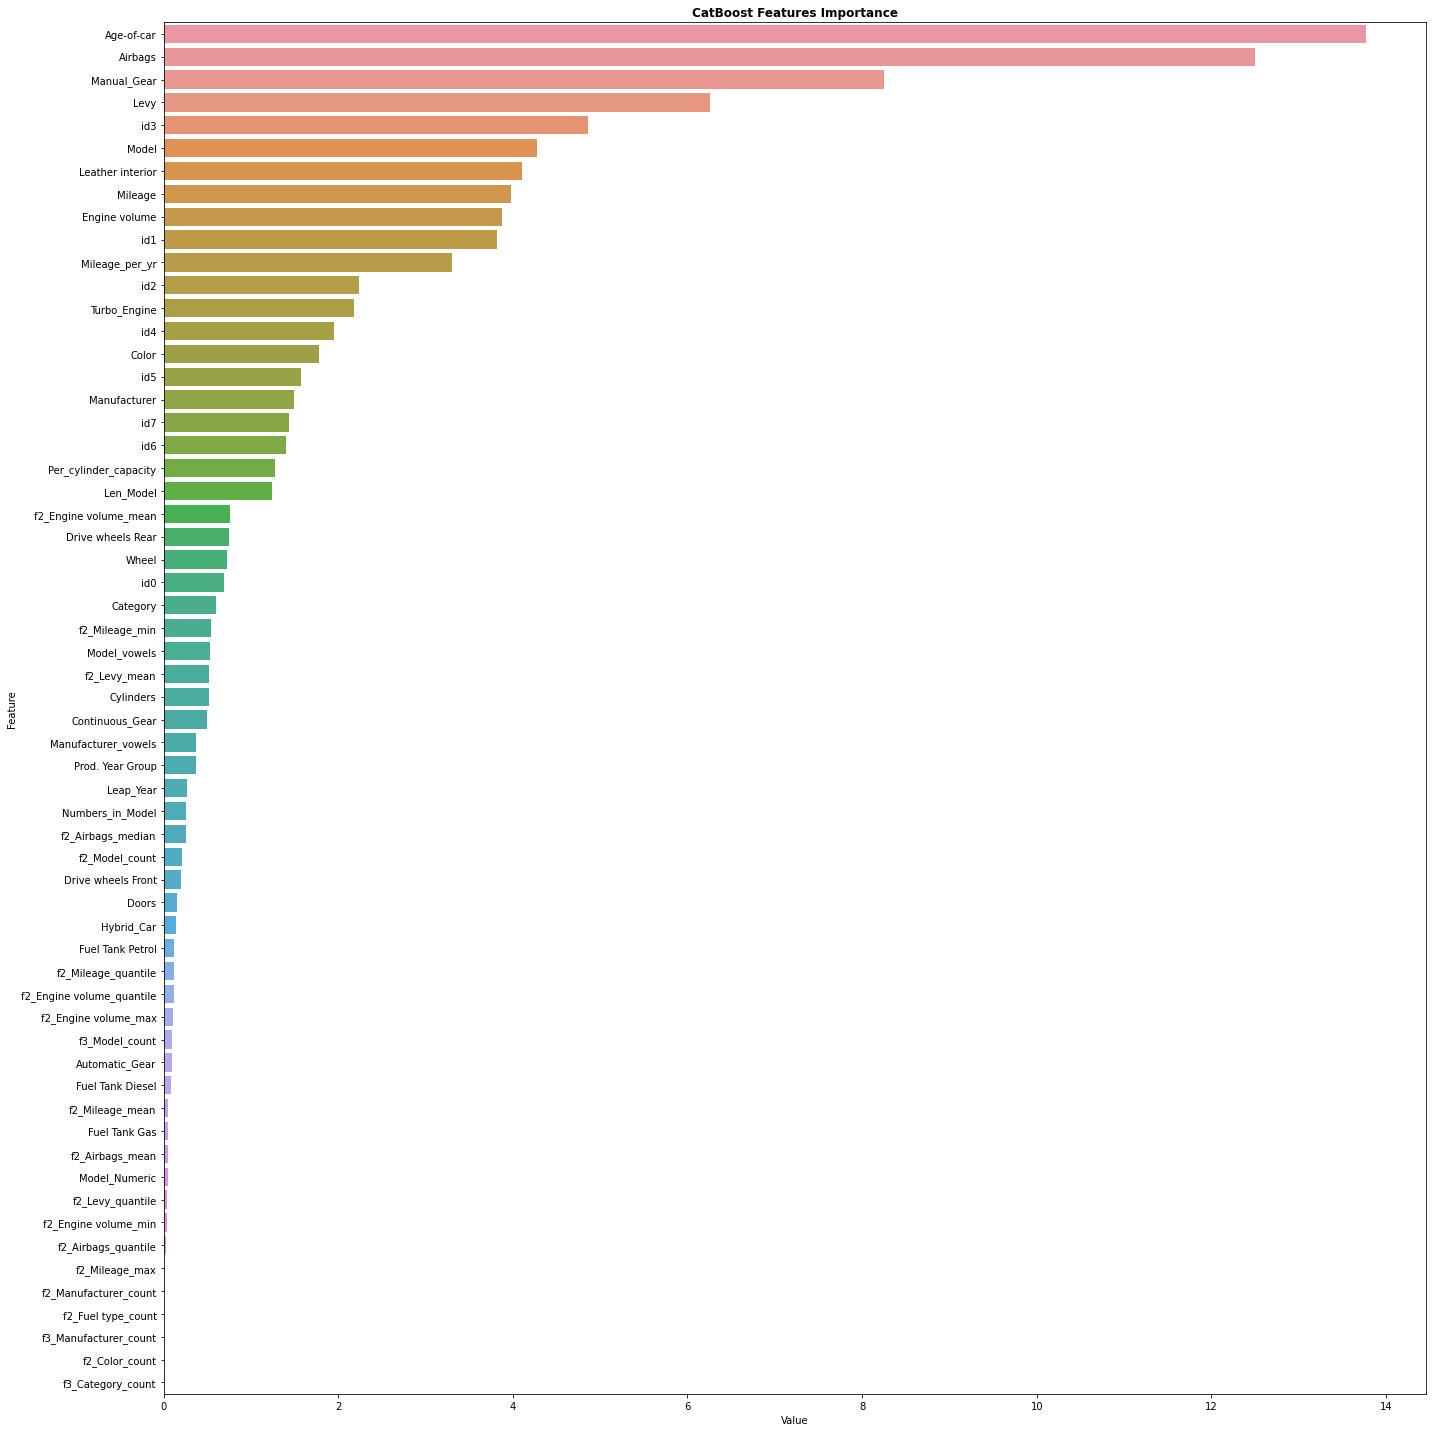

In [13]:
fet_imp = (fet_imp1 + fet_imp2)/2.0
feature_imp = pd.DataFrame(sorted(zip(fet_imp[0:60],Xtrain.columns[0:60])), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('CatBoost Features Importance', fontweight='bold')
plt.tight_layout()
plt.show()